In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

# Parametros
L = 40  # Tamaño del dominio (en unidades adimensionales)
N = 3000 # Numero de puntos espaciales
dx = L / N  # Paso espacial
xi = np.linspace(-L / 2, L / 2, N)  # Grid espacial en unidades adimensionales
dt = 0.0005  # Paso temporal (en unidades adimensionales)
t_max = 6.24 # Tiempo final (tiempo maximo tuneleo)
t_steps = int(t_max / dt)  # Numero de pasos temporales



# Parámetros del paquete de ondas, función de onda input
xi0 = -4 # Posición inicial partícula
kappa_0 = 4 # Momento Inicial
psi0 = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa_0 * xi)



# Barrera de potencial
alpha_param = 6  
v_0 = 0 # Altura del potencial (V_0/Ec)
b = 1 # Grosor de la barrera (en unidades adimensionales, realmente es xi_b)
v = v_0 / (1 + np.abs(xi / b)**alpha_param)  # Forma explicita del potencial

In [21]:
alpha = 1j * dt / (kappa_0 * dx**2)  
beta = 1j * dt * kappa_0 / 2  

diagonal_a = (1 + alpha + beta * v) * np.ones(N)
off_diagonal = -(alpha / 2) * np.ones(N - 1)
A = diags([off_diagonal, diagonal_a, off_diagonal], [-1, 0, 1], format="csr")

diagonal_b = (1 - alpha - beta * v) * np.ones(N)
B = diags([-off_diagonal, diagonal_b, -off_diagonal], [-1, 0, 1], format="csr")

In [22]:
def perform_momentum_measurement(psi, xi, N):
   
    dx = xi[1] - xi[0]  

    # TF para encontrar psi en espacio de k
    psi_k = np.fft.fft(psi) * dx  # dx para normalizar al dicretizar la versión continua de TF
    k_values = np.fft.fftfreq(N, d=dx) # grid del espacio de momentos

    # Producto por theta de heaviside
    positive_k_indices = k_values > 0
    psi_k_positive = psi_k[positive_k_indices]
    
    # Conserva el tamaño del espacio
    psi_k_full = np.zeros(N, dtype=complex)
    psi_k_full[positive_k_indices] = psi_k_positive

    # Devuelve al espacio de xi
    psi_measured = np.fft.ifft(psi_k_full) # TF inversa

    # Normalizar (pendiente)
    normalization_factor = np.sqrt(trapezoid(np.abs(psi_measured)**2, xi))
    psi_measured /= normalization_factor

    return psi_measured

In [23]:
def calculate_positive_kappa_probability(psi, xi):
    
    dx = xi[1] - xi[0]  

    psi_k = np.fft.fft(psi) * dx  
    k_values = np.fft.fftfreq(len(xi), d=dx)  

    positive_k_indices = k_values > 0
    psi_k_positive = psi_k[positive_k_indices]

    # Probabilidad kappa positivo
    probability_positive_kappa = np.sum(np.abs(psi_k_positive)**2) 

    # Normalizar
    normalization_factor = np.sum(np.abs(psi_k)**2)  
    if normalization_factor > 0:
        probability_positive_kappa /= normalization_factor  

    return probability_positive_kappa


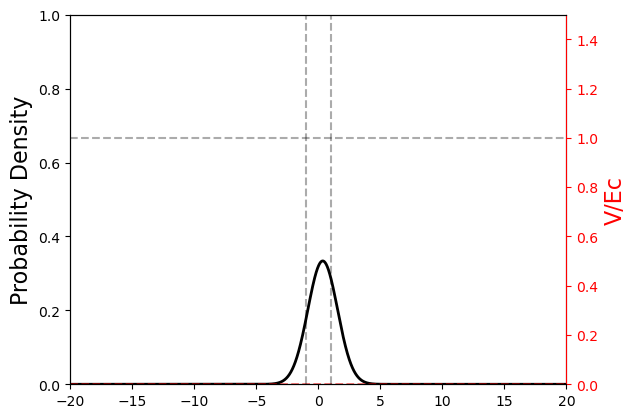

In [24]:
# Plot
fig, ax = plt.subplots()

# Plot de la densidad de probabilidad
ax.set_xlim(-L/2, L/2)
ax.set_ylim(0, 1)  
line, = ax.plot(xi, np.abs(psi)**2, label=f't={t_max}',color='k',linewidth=2) # plot de |psi|^2
ax.set_ylabel('Probability Density', size=16)

# Plot de la barrera
ax.plot(xi, v*(2/3), color='r', linestyle='--', label='Potential Barrier',alpha = 0.65 )

# Eje para la barrera
ax2 = ax.twinx()  
ax2.set_ylim(0, 1.5)  # Límite = max barrera pot
ax2.set_ylabel('V/Ec',color='r',size = 16)
ax2.tick_params(axis='y', colors='red')  
ax2.spines['right'].set_color('red') 


ax2.axhline(y=1, color='black', linestyle='--',alpha = 0.33)

plt.axvline(x=b, color='k', linestyle='--', alpha=0.33)
plt.axvline(x=-b, color='k', linestyle='--', alpha=0.33)

In [25]:
from matplotlib.animation import FuncAnimation

t_max = 15
t_steps = int(t_max / dt) 

# Inicialización de la función de onda
psi = psi0.copy()

num_frames = 400  
steps_per_frame = t_steps // num_frames  

# Función para actualizar el gráfico en cada paso de tiempo
def update(frame):
    global psi
    for step in range(steps_per_frame):  # Evoluciona la función de onda varios pasos en cada cuadro
        psi = spsolve(A, B @ psi)
    line.set_ydata(np.abs(psi)**2)  # Actualizar la densidad de probabilidad
    current_time = frame * steps_per_frame * dt
    print(current_time)
    ax.set_title(f't = {current_time:.3f}, b = {b}, L = {L}, v_0 = {v_0}, dt/dx² = {round(dt/(dx**2),5)}, N={N}')  # Actualizar el título 
    return line,

# Crear la animación
ani = FuncAnimation(fig, update, frames=num_frames, blit=True)

ani.save('tuneleo_animacion.mp4', writer='ffmpeg', fps=30)

0.0
0.0
0.0
0.0
0.0375
0.075
0.1125
0.15
0.1875
0.225
0.2625
0.3
0.3375
0.375
0.41250000000000003
0.45
0.4875
0.525
0.5625
0.6
0.6375000000000001
0.675
0.7125
0.75
0.7875
0.8250000000000001
0.8625
0.9
0.9375
0.975
1.0125
1.05
1.0875000000000001
1.125
1.1625
1.2
1.2375
1.2750000000000001
1.3125
1.35
1.3875
1.425
1.4625000000000001
1.5
1.5375
1.575
1.6125
1.6500000000000001
1.6875
1.725
1.7625
1.8
1.8375000000000001
1.875
1.9125
1.95
1.9875
2.025
2.0625
2.1
2.1375
2.1750000000000003
2.2125
2.25
2.2875
2.325
2.3625000000000003
2.4
2.4375
2.475
2.5125
2.5500000000000003
2.5875
2.625
2.6625
2.7
2.7375000000000003
2.775
2.8125
2.85
2.8875
2.9250000000000003
2.9625
3.0
3.0375
3.075
3.1125000000000003
3.15
3.1875
3.225
3.2625
3.3000000000000003
3.3375
3.375
3.4125
3.45
3.4875000000000003
3.525
3.5625
3.6
3.6375
3.6750000000000003
3.7125
3.75
3.7875
3.825
3.8625000000000003
3.9
3.9375
3.975
4.0125
4.05
4.0875
4.125
4.1625
4.2
4.2375
4.275
4.3125
4.3500000000000005
4.3875
4.425
4.4625
4.5
4.5375